In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

In [3]:
from matplotlib.lines import Line2D      

def plot_grad_flow(named_parameters, epoch, loss, acc, savepath):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):

            try:
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
                layers.append(n)
            except:
                continue
#                 ave_grads.append(0.)
#                 max_grads.append(0.)
#                 layers.append(n)
                
    plt.figure(figsize=(10,10))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.5, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.5, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow | Epoch " + str(epoch) + " | ls: " + str(loss) + " | ac: " + str(acc))
    plt.tight_layout()
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    
    if not savepath is None:
        plt.savefig(savepath)
        
    plt.close()
    
    

In [4]:
import torch
from torchvision import transforms, datasets

train_data_transform = transforms.Compose([
        
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=150),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=train_data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=test_data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=test_data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [5]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        
        x1 = x1 + x0_res
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = self.relu(x2)
        
        x2 = x2 + x1_res
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = self.relu(x3)
        
        x3 = x3 + x2_res

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out

In [11]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim):
        super(Attention, self).__init__()
        self.emb_dim = emb_dim
        self.sub_conv1 = nn.Conv2d(feature_depth, feature_depth, kernel_size=2, padding=0, stride=2)
        self.iconv1 = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.iconv2 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        
        self.iconv_in_1 = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.iconv_in_2 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        
        self.iconv_out = nn.Conv2d(2*emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)
        
        
    def forward(self, x1, x2):
        x1_sampling = self.sub_conv1(x1)
        x1_emb = self.iconv1(x1_sampling)
        _x1 = nn.Flatten(-2)(x1_emb)
        
        x2_emb = self.iconv2(x2)
        _x2 = nn.Flatten(-2)(x2_emb)
        
        in_x2_emb = self.iconv_in_2(x2)
        _in_x2 = nn.Flatten(-2)(in_x2_emb)
        
        in_x1_emb = self.iconv_in_1(x1_sampling)
        _in_x1 = nn.Flatten(-2)(in_x1_emb)

        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / math.sqrt(_x1.size(2))

        x_out_2 = torch.matmul(QK, _in_x2)
        x_out_2 = x_out_2.reshape(in_x2_emb.size())
        
        x_out_1 = torch.matmul(QK.permute(0,2,1), _in_x1)
        x_out_1 = x_out_1.reshape(in_x1_emb.size())

        x_out = torch.cat([x_out_2, x_out_1], dim=1)
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU()(x_out)
        
        return x_out

In [12]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

#         self.wf0 = Attention(1, 64, emb_dim=32).to(self.device)
        self.wf1 = Attention(64, 128, emb_dim=64).to(self.device)
        self.wf2 = Attention(128, 256, emb_dim=128).to(self.device)
        self.wf3 = Attention(256, 512, emb_dim=256).to(self.device)
        self.wf4 = Attention(512, 1024, emb_dim=512).to(self.device)
        
        self.iconv_out = nn.Conv2d(1024, 1024, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(1024)

        self.fc0 = nn.Linear(2560, 2560)
        self.bn0 = nn.BatchNorm1d(2560)
        self.fc1 = nn.Linear(2560, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
#         x_wf0 = self.wf0(x, x0)

        x1 = self.sv1(x0)
        x_wf1 = self.wf1(x0, x1)

        x2 = self.sv2(x_wf1)
        x_wf2 = self.wf2(x1, x2)

        x3 = self.sv3(x_wf2)
        x_wf3 = self.wf3(x2, x3)

        x4 = self.sv4(x_wf3)
        x_wf4 = self.wf4(x3, x4)
        
        x_wf4 = self.iconv_out(x_wf4)
        x_wf4 = self.bn_out(x_wf4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
        x_wf4 = nn.Flatten()(x_wf4)
        # additional output from sv3 and sv4
        x_sub_3 = nn.AvgPool2d(kernel_size=(x3.size(-2), x3.size(-1)))(x3)
        x_sub_3 = nn.Flatten()(x_sub_3)
        x_sub_4 = nn.AvgPool2d(kernel_size=(x4.size(-2), x4.size(-1)))(x4)
        x_sub_4 = nn.Flatten()(x_sub_4)
        
        x = torch.cat([x_wf4, x_sub_3, x_sub_4], dim=1)

        x = self.fc0(x)
        x = self.bn0(x)
        x = nn.LeakyReLU()(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x

In [13]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
reduce_factor = 10
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


cuda


In [14]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics/attention_v2/'
model_name = 'svgg_resnet'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(350):  # loop over the dataset multiple times
    
    
    
    if (epoch % 30) == 0 and epoch != 0 and learning_rate > 1e-6:
        learning_rate /= reduce_factor
        print('Decrese learning rate to: ', learning_rate)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
    plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
                   savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
- Avg.loss: 1.851  | Avg.acc: 0.243
- Avg. val_loss: 1.803  | Avg. val_acc: 0.254
* Update optimal model
Epoch:  2
- Avg.loss: 1.793  | Avg.acc: 0.252
- Avg. val_loss: 1.849  | Avg. val_acc: 0.256
* Update optimal model
Epoch:  3
- Avg.loss: 1.783  | Avg.acc: 0.253
- Avg. val_loss: 1.849  | Avg. val_acc: 0.263
* Update optimal model
Epoch:  4
- Avg.loss: 1.779  | Avg.acc: 0.255
- Avg. val_loss: 20.595  | Avg. val_acc: 0.253
Epoch:  5
- Avg.loss: 1.776  | Avg.acc: 0.258
- Avg. val_loss: 1.921  | Avg. val_acc: 0.265
* Update optimal model
Epoch:  6
- Avg.loss: 1.773  | Avg.acc: 0.261
- Avg. val_loss: 1.809  | Avg. val_acc: 0.244
Epoch:  7
- Avg.loss: 1.767  | Avg.acc: 0.267
- Avg. val_loss: 1.796  | Avg. val_acc: 0.259
Epoch:  8
- Avg.loss: 1.749  | Avg.acc: 0.280
- Avg. val_loss: 1.809  | Avg. val_acc: 0.262
Epoch:  9
- Avg.loss: 1.729  | Avg.acc: 0.292
- Avg. val_loss: 1.753  | Avg. val_acc: 0.275
* Update optimal model
Epoch:  10
- Avg.loss: 1.709  | Avg.acc: 0.303
- Avg. va

- Avg.loss: 1.055  | Avg.acc: 0.600
- Avg. val_loss: 1.094  | Avg. val_acc: 0.588
Epoch:  83
- Avg.loss: 1.056  | Avg.acc: 0.601
- Avg. val_loss: 1.121  | Avg. val_acc: 0.576
Epoch:  84
- Avg.loss: 1.053  | Avg.acc: 0.602
- Avg. val_loss: 1.085  | Avg. val_acc: 0.591
* Update optimal model
Epoch:  85
- Avg.loss: 1.057  | Avg.acc: 0.599
- Avg. val_loss: 1.112  | Avg. val_acc: 0.578
Epoch:  86
- Avg.loss: 1.051  | Avg.acc: 0.600
- Avg. val_loss: 1.099  | Avg. val_acc: 0.589
Epoch:  87
- Avg.loss: 1.050  | Avg.acc: 0.604
- Avg. val_loss: 1.096  | Avg. val_acc: 0.587
Epoch:  88
- Avg.loss: 1.050  | Avg.acc: 0.605
- Avg. val_loss: 1.107  | Avg. val_acc: 0.590
Epoch:  89
- Avg.loss: 1.047  | Avg.acc: 0.603
- Avg. val_loss: 1.122  | Avg. val_acc: 0.577
Epoch:  90
- Avg.loss: 1.048  | Avg.acc: 0.603
- Avg. val_loss: 1.119  | Avg. val_acc: 0.589
Decrese learning rate to:  1e-05
Epoch:  91
- Avg.loss: 1.036  | Avg.acc: 0.610
- Avg. val_loss: 1.092  | Avg. val_acc: 0.588
Epoch:  92
- Avg.loss: 1.

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 7.79 GiB total capacity; 5.39 GiB already allocated; 108.69 MiB free; 5.96 GiB reserved in total by PyTorch)

([<matplotlib.lines.Line2D at 0x7f9c07c48080>,
 0.5911637935145148,
 1.0871883281346024)

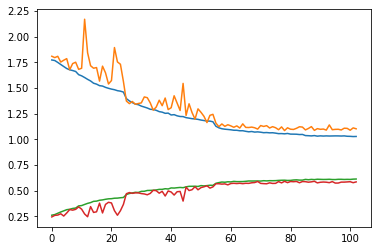

In [17]:
plt.plot(hist[5:]), best_acc, curloss

In [20]:
import imageio
images = []
for i in range(109):
    images.append(imageio.imread('/tf/data/Quan/fer2013/backtobasics/attention_v2/svgg_resnet_gf_' + str(i) + '.png'))
imageio.mimsave('/tf/data/Quan/fer2013/backtobasics/attention_v2/svgg_resnet_gf.gif', images)